## Sprint9 ニューラルネットワーク

In [33]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

In [34]:
# # データ用意
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# # * 正解ラベル→0から9の整数,NNの多クラス分類を行う際はone-hot表現に変換(0-1)
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)#ワンホットエンコードインスタンス化
# y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])#trainTransfrom
# y_test_one_hot = enc.transform(y_test[:, np.newaxis])#testTransform

# # データ確認
# print(y_train.shape) # (60000,)
# print(y_train_one_hot.shape) # (60000, 10)
# print(y_train_one_hot.dtype) # float64

# # 描画
# index = 0
# image = x_train[index]
# plt.imshow(image, 'gray')
# plt.title('label : {}'.format(y_train[index]))
# plt.show()

# # 2次元→1次元（画像データ→行データ）
# # x_train = np.ravel(x_train)
# # x_test = np.ravel(x_test)
# # x_train = np.ravel(x_train)
# # x_test = np.ravel(x_test)
# # x_train = XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# # x_test = XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
# x_train = x_train.reshape(-1, 784)
# x_test = x_test.reshape(-1, 784)
# print(x_train.shape)
# print(x_test.shape)
# print(x_train.dtype)
# print("訓練データ全体",x_train.shape) 
# # print("テストデータ全体",x_test.shape) 
# # print("訓練データの1つのデータ",x_train[0].shape)
# # print("訓練データの1つのデータの型",x_train[0].dtype) 


# # NNの入力値にするため、Xのデータも0-1におさめる処理
# x_train = x_train.astype(np.float)#2.365044290627876e-10
# x_test = x_test.astype(np.float)#0.0

# x_train /= 255
# x_test /= 255
# print('・入力値を０〜１の間に調整↓')
# print(x_train.max()) 
# print(x_train.min())


# # 分割
# x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
# print('・分割後の確認↓')
# print(x_train.shape) # (48000, 784[2828])
# print(x_test.shape) # (12000, 784)
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_val[:, np.newaxis])



In [35]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [49]:
# nn
class ScratchSimpleNeuralNetrowkClassifier:
    def __init__(self,batch_size= 20,n_features= 784,n_nodes1= 400,n_nodes2= 200,n_output= 10,sigma= 0.02,lr= 0.01,epoch= 10, verbose=True):

        self.verbose = verbose#verbose : 計算過程を出力するか否か
        self.batch_size = batch_size#batch_size : ミニバッチのデータ数
        self.n_features = n_features#n_features : 説明変数の数
        self.n_nodes1 = n_nodes1#1層目のノードの数
        self.n_nodes2 = n_nodes2#2層目のノードの数 
        self.n_output = n_output#出力層のノードの数
        self.sigma = sigma#重みの初期化の際のガウス分布の標準偏差
        self.lr = lr#学習率
        self.epoch = epoch#学習回数（単位）
        # 損失記録用
        self.loss_train = []
        self.loss_test = []
        self.f_loss_list = []

        # 問題１
        # 使用する重みの初期化
        # 一層目の重みから三層目までの重みまで

        # 重み初期値
        # np.random.normal(0.0, pow(ニューロン数, -0.5), 行, 列)
        # 入力層→隠れ層→出力層にかけてニューロンがへる(ハイパーパラメーターで設定する))
        self.W1 = self.sigma * np.random.normal(0.0, pow(self.n_nodes1, -0.5), (self.n_features, self.n_nodes1))# (784, 400)
        self.W2 = self.sigma * np.random.normal(0.0, pow(self.n_nodes2, -0.5), (self.n_nodes1, self.n_nodes2))# (400, 200)
        self.W3 = self.sigma * np.random.normal(0.0, pow(self.n_output, -0.5), (self.n_nodes2, self.n_output))# (200, 10)
        # DICの歯抜けコードでは以下
        # self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)# (784, 400)
        # self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)# (400, 200)
        # self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)# (200, 10)

        # print(self.W1.shape)
        # print(self.W2.shape)
        # print(self.W3.shape)

        # 全て完成したら、W1〜W3までを以下の重み初期値に変えて実装してみる
        # self.W1 = np.ramdom.normal(0.0, pow(self.n_nodes1, -0.5), (self.n_nodes2, self.n_nodes1+1))
        # self.W2 = np.ramdom.normal(0.0, pow(self.n_nodes2, -0.5), (self.n_output, self.n_nodes2+1))
        # self.W3 = np.ramdom.normal(0.0, pow(self.n_nodes2, -0.5), (self.n_output, self.n_nodes2+1))

        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)# (1, 400)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)# (1, 200)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)# (1, 10)

        # print(self.B1.shape)
        # print(self.B2.shape)
        # print(self.B3.shape)

        
    def fit(self, x, y, x_test=None, y_test=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        x : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        x_test : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_test : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 学習回数分ループ
        for _ in range(self.epoch):
            
            # 先ほど定義したミニバッチイテレータのインスタンス化
            # self._counter*self.batch_size + self.batch_size
            get_mini_batch = GetMiniBatch(x, y, batch_size=20)
            # get_mini_batch = GetMiniBatch(x_train, y_train, batch_size=20)
            
            # ミニバッチイテレータが停止するまでバッチ学習
            # get_mini_batchを呼び出すたびに、説明変数と目的変数が返ってくる
            for mini_x_train, mini_y_train in get_mini_batch:
                # 順伝播
                self.forward_propagation(mini_x_train)
                # 逆伝播
                self.backward_propagation(mini_x_train, mini_y_train)
                
            # ミニバッチ学習後のロス計算
            self.forward_propagation(x)
            # loss = self.Z3 - y
            # self.f_loss_list.append(loss[-1])
            # print(self.cross_entropy_error(y, self.Z3))
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            # Testもありきで計算する（loss）
            if x_test is not None:
                self.forward_propagation(x_test)
                self.loss_test.append(self.cross_entropy_error(y_test, self.Z3))
        
        # 学習過程の出力
        if self.verbose:
            if x_test is None:
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_test)

    # 問題２ ゼロつく58ページ参照
    # 入力層から出力層まで
    def forward_propagation(self, x):
        """順伝播
        Parameters
        ----------
        x : 説明変数
        """
        # X1 = np.array(np.append(x, [1]),ndmin=2).T
        ## 1層目
        self.A1 = x @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        
        ## 2層目
        self.A2 = self.Z1 @ self.W2 + self.B2
        # self.Z2 = self.tanh_function(self.A2)
        self.Z2 = self.sigmoid(self.A2)
        
        ## 3層目（出力層）
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)
        # ※活性化関数の違いを要復習
        # メンバ変数self.Z3がNNの出力となる
        # print(self.Z3)
        return self.Z3

        # # 問題４
    def backward_propagation(self, x, y):
        """逆順伝播
        Parameters
        ----------
        x : 説明変数
        """
        ## 3層目（出力層）
        # 3層目の重みに対する勾配
        # self.Z3＝forward_propagationの出力値
        
        # print(y)
        dA3 = self.forward_propagation(x) - y
        # dA3 = self.Z3 - y
        dW3 = self.Z2.T @ dA3
        # 3層目のバイアス項に対する勾配
        dB3 = np.sum(dA3, axis=0)
        
        ## 2層目
        # 2層目の重みに対する勾配
        dZ2 = dA3 @ self.W3.T
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dW2 = self.Z1.T @ dA2
        # 2層目のバイアス項に対する勾配
        dB2 = np.sum(dA2, axis=0)
        
        ## 1層目
        # 1層目の重みに対する勾配
        dZ1 = dA2 @ self.W2.T
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dW1 = x.T @ dA1
        # 1層目のバイアス項に対する勾配
        dB1 = np.sum(dA1, axis=0)
        
        # 問題4
        # バックプロパゲーションの更新式
        # 三層目
        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        # 二層目（隠れそう）
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        # 一層目（出力層）
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1
    
    # 問題２
    def tanh_function(self, A):
        #活性化関数tanh
        return np.tanh(A)

    # 問題２
    def softmax(self, A):
        #softmax
        # オーバーフロー対策の場合のコード
        # a_max = np.max(A)
        # exp_a = np.exp(A - a_max)
        # --------------------

        # exp_a = np.exp(A)
        # sum_exp_a = np.sum(exp_a, axis=1)
        # s = exp_a / sum_exp_a
        return np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)#s.reshape(-1, 1)

    def sigmoid(self, x):
        sig = 1 / (1 + np.exp(-x))
        return sig

    # 問題３
    def cross_entropy_error(self, y, Z):
        """損失関数 交差エントロピー誤差
        Parameters
        ----------
        y : 正解データ
        Z : 予測値
        """
        # if y.ndim == 1:
        #     Z = reshape(1, Z.size)
        #     y = reshape(1, y.size)
        # delta = 1e-7
        # batch_s = y.shape[0]
        # an = -np.sum(Z * np.log(y + delta)) / batch_s
        # バッチサイズ＝yでわる
        # error = -np.sum(Z * np.log(y + delta))
        L = - np.sum(y * np.log(Z)) / len(y)
        return L#an

    def predict(self, x):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        x : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # 順伝播処理
        # self.forward(X)
        self.forward_propagation(x)
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(self.Z3, axis=1)
        
# X = np.array([np.concatenate([1], v) for v in x_train])
# X1 = np.array(np.append(x_train, [1]),ndmin=2).T
# print(X1.shape)
# print(X1)#(47040001, 1)
# print(X.shape)
# print(X)

[0.23149872806604407, 0.14998234570541372, 0.10215857891161977, 0.07701919928269836, 0.05692476140885889, 0.045288216013640206, 0.033480739239746066, 0.026400859271951085, 0.024631277033316797, 0.017252928155227942, 0.013064924928045432, 0.009004150850264875, 0.006760937606930985, 0.004667734437557849, 0.0034529190436563806] [0.23002087727136977, 0.16417851095858077, 0.12694383546313062, 0.10910952765874447, 0.09771992514363982, 0.0933236494550183, 0.08735197207573867, 0.08755675647898846, 0.09029649803574705, 0.08682833518640064, 0.08879349502743102, 0.08501400430569642, 0.08446625792754447, 0.08507611235358543, 0.08603190783935635]
[0.23149872806604407, 0.14998234570541372, 0.10215857891161977, 0.07701919928269836, 0.05692476140885889, 0.045288216013640206, 0.033480739239746066, 0.026400859271951085, 0.024631277033316797, 0.017252928155227942, 0.013064924928045432, 0.009004150850264875, 0.006760937606930985, 0.004667734437557849, 0.0034529190436563806]
[0.23002087727136977, 0.1641785

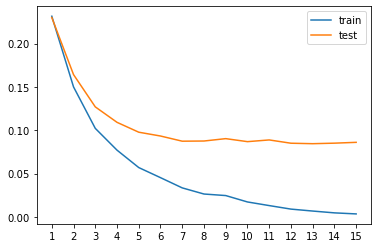

In [66]:
# インスタンス化
# nn = ScratchSimpleNeuralNetrowkClassifier(batch_size= 20,n_features= 784,n_nodes1= 400,n_nodes2= 200,n_output= 10,sigma= 0.02,lr= 0.01,epoch= 15, verbose=True)
# # print(nn.forward_propagation(x_train[:10000]))
# # print(nn.backward_propagation(x_train[:10000], y_train_one_hot[:10000]))
# # 学習
# nn.fit(x_train[:10000],y_train_one_hot[:10000], x_test[:10000], y_test_one_hot)
# # # nn.fit(x_train[:10000],y_train_one_hot[:10000], x_test, y_test_one_hot)
# # 予測
# pred_train = nn.predict(x_train)
# pred_test = nn.predict(x_test)
# print(pred_train)
# print(pred_test)

NN = ScratchSimpleNeuralNetrowkClassifier(batch_size= 20,n_features= 784,n_nodes1= 400,n_nodes2= 200,n_output= 10,sigma= 0.02,lr= 0.01,epoch= 15, verbose=True)

NN.fit(X_train, y_train_one_hot, X_val, y_test_one_hot)

pred_train = NN.predict(X_train)
pred_test = NN.predict(X_val)

print(NN.loss_train)
print(NN.loss_test)

plt.plot(list(range(1, NN.epoch+1)), NN.loss_train, label='train')
plt.plot(list(range(1, NN.epoch+1)), NN.loss_test, label='test')
plt.legend()
plt.xticks(list(range(1, NN.epoch+1)));


## 問題６

In [63]:
# print(y_train)
# print(pred_train)
# print(y_test)
# print(pred_test)
print(y_train.shape)
print(pred_train.shape)

print(y_test.shape)
print(pred_test.shape)

print(y_train_one_hot.shape)
print(y_test_one_hot.shape)
print(f'正解率 : \n y_train: {accuracy_score(y_train, pred_train)},\n y_test : {accuracy_score(y_test, pred_test[:10000])}')
# 初期値変更前 (0.09935416666666666, 0.09833333333333333)
# 初期値変更後 (0.09935416666666666, 0.098333333333333339)


# めちゃ過学習してる
#  y_train: 0.9949166666666667,
#  y_test : 0.0969


(48000,)
(48000,)
(10000,)
(12000,)
(48000, 10)
(12000, 10)
正解率 : 
 y_train: 0.9949166666666667,
 y_test : 0.0969


[0.23149872806604407, 0.14998234570541372, 0.10215857891161977, 0.07701919928269836, 0.05692476140885889, 0.045288216013640206, 0.033480739239746066, 0.026400859271951085, 0.024631277033316797, 0.017252928155227942, 0.013064924928045432, 0.009004150850264875, 0.006760937606930985, 0.004667734437557849, 0.0034529190436563806]
[0.23002087727136977, 0.16417851095858077, 0.12694383546313062, 0.10910952765874447, 0.09771992514363982, 0.0933236494550183, 0.08735197207573867, 0.08755675647898846, 0.09029649803574705, 0.08682833518640064, 0.08879349502743102, 0.08501400430569642, 0.08446625792754447, 0.08507611235358543, 0.08603190783935635]


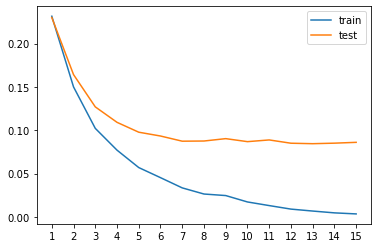

In [67]:
# print(list(range(1, NN.epoch+1)))
print(NN.loss_train)
print(NN.loss_test)
# print(NN.f_loss_list[0])

# plt.plot(list(range(1, NN.epoch+1)), NN.f_loss_list, label='train')
plt.plot(list(range(1, NN.epoch+1)), NN.loss_train, label='train')
plt.plot(list(range(1, NN.epoch+1)), NN.loss_test, label='test')
plt.legend()
plt.xticks(list(range(1, NN.epoch+1)));